<a href="https://colab.research.google.com/github/Papekyan/GBM-und-XG/blob/main/cardiorichtig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risikofaktoren für Kardiovaskuläre Herzkrankheiten


# 0. Import von Bibliotheken und Datenveranschaulichung

In [ ]:

import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns #Visualisierung
import matplotlib.pyplot as plt #Visualisierung
from sklearn.model_selection import train_test_split #Split Training- und Testdaten
from sklearn.metrics import recall_score,precision_score, confusion_matrix, classification_report #Evaluation
from sklearn.ensemble import GradientBoostingClassifier #GBM
from sklearn.model_selection import GridSearchCV #hyperparameter tuning
from xgboost import XGBClassifier #XGBoost
from xgboost import plot_tree




# 1. Datenveranschaulichung

In [ ]:
df = pd.read_csv('heart_data.csv')

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        70000 non-null  int64  
 1   id           70000 non-null  int64  
 2   age          70000 non-null  int64  
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,20207.403759,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.750000,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,34999.500000,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,52499.250000,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,69999.000000,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info(-3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        70000 non-null  int64  
 1   id           70000 non-null  int64  
 2   age          70000 non-null  int64  
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


In [ ]:
#Kardinalität der Spalten
print(df.nunique())

index          70000
id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64


# 2. Datenaufbereitung

In [ ]:
#Alter in Jahre umrechnen
df['age_years'] = df ['age']/365

In [ ]:
#OHE für gluc und cholesterol kategoriale Werte
df = pd.get_dummies(df, columns=(['gluc','cholesterol']),  drop_first=False)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df = df.drop(['index','id','height','weight'],axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            70000 non-null  int64  
 1   gender         70000 non-null  int64  
 2   ap_hi          70000 non-null  int64  
 3   ap_lo          70000 non-null  int64  
 4   smoke          70000 non-null  int64  
 5   alco           70000 non-null  int64  
 6   active         70000 non-null  int64  
 7   cardio         70000 non-null  int64  
 8   age_years      70000 non-null  float64
 9   gluc_1         70000 non-null  bool   
 10  gluc_2         70000 non-null  bool   
 11  gluc_3         70000 non-null  bool   
 12  cholesterol_1  70000 non-null  bool   
 13  cholesterol_2  70000 non-null  bool   
 14  cholesterol_3  70000 non-null  bool   
 15  bmi            70000 non-null  float64
dtypes: bool(6), float64(2), int64(8)
memory usage: 5.7 MB


In [ ]:
#Umbennen der Spaltennamen
df.rename(columns={
    'gluc_1': 'gluc_low',
    'gluc_2': 'gluc_med',
    'gluc_3': 'gluc_high',
    'cholesterol_1': 'cholesterol_low',
    'cholesterol_2': 'cholesterol_med',
    'cholesterol_3': 'cholesterol_high'
}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               70000 non-null  int64  
 1   gender            70000 non-null  int64  
 2   ap_hi             70000 non-null  int64  
 3   ap_lo             70000 non-null  int64  
 4   smoke             70000 non-null  int64  
 5   alco              70000 non-null  int64  
 6   active            70000 non-null  int64  
 7   cardio            70000 non-null  int64  
 8   age_years         70000 non-null  float64
 9   gluc_low          70000 non-null  bool   
 10  gluc_med          70000 non-null  bool   
 11  gluc_high         70000 non-null  bool   
 12  cholesterol_low   70000 non-null  bool   
 13  cholesterol_med   70000 non-null  bool   
 14  cholesterol_high  70000 non-null  bool   
 15  bmi               70000 non-null  float64
dtypes: bool(6), float64(2), int64(8)
memory 

In [ ]:
#Aufteilung des Datensatzes in Prädiktoren und Zielwerte
X = df.drop('cardio',axis=1)
Y = df['cardio']

cardio
0    35021
1    34979
Name: count, dtype: int64


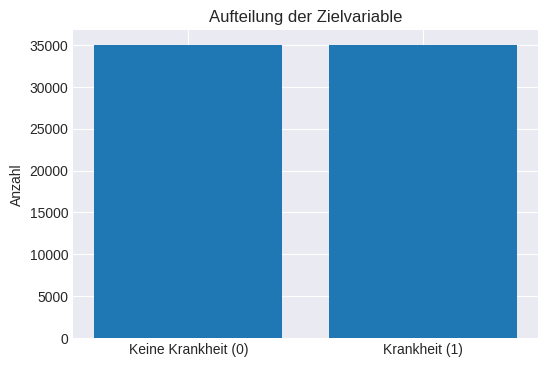

In [ ]:
#Aufteilung der Zielvariable
print(Y.value_counts())

plt.style.use('seaborn-v0_8-darkgrid')
counts = df['cardio'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)

plt.ylabel('Anzahl')
plt.title('Aufteilung der Zielvariable')
plt.xticks([0,1 ], ['Keine Krankheit (0)','Krankheit (1)'])
plt.show()


In [ ]:
#Überprüfen ob NaN Werte vorhanden sind
X.isnull().sum()

,0
age,0
gender,0
ap_hi,0
ap_lo,0
smoke,0
alco,0
active,0
age_years,0
gluc_low,0
gluc_med,0


# 3. Anwendung Gradient Boosting Classifier

In [ ]:
#Daten spliten und Modell trainieren
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
gbr = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3,verbose=1)
gbr = gbr.fit(X_train, Y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3381           10.08s
         2           1.2989           10.18s
         3           1.2666           10.36s
         4           1.2399           10.32s
         5           1.2175           10.23s
         6           1.1989           10.06s
         7           1.1833            9.88s
         8           1.1699            9.78s
         9           1.1589            9.69s
        10           1.1494            9.59s
        20           1.1037            8.69s
        30           1.0896            7.50s
        40           1.0828            6.37s
        50           1.0789            5.28s
        60           1.0765            4.20s
        70           1.0746            3.15s
        80           1.0732            2.12s
        90           1.0718            1.11s
       100           1.0709            0.00s


In [ ]:
#Trainiertes Modell auf Test Set anwende
Y_pred = gbr.predict(X_test)

In [ ]:
#Evaluationsreport und Konfusionsmatrix generieren
report = classification_report(
    Y_test,
    Y_pred,
    labels=[1, 0],
    target_names=["Disease (1)", "No Disease (0)"],
    digits=4
)

print("Classification Report:")
print(report)


cm = confusion_matrix(Y_test, Y_pred, labels=[1, 0])
print(cm)

Classification Report:
                precision    recall  f1-score   support

   Disease (1)     0.7566    0.7081    0.7315      7012
No Disease (0)     0.7248    0.7715    0.7474      6988

      accuracy                         0.7397     14000
     macro avg     0.7407    0.7398    0.7395     14000
  weighted avg     0.7407    0.7397    0.7395     14000

[[4965 2047]
 [1597 5391]]


## 3.1 Hyperparamter Tuning

In [ ]:
#Parameter festlegen über die varriert werden darf
param_grid = {
    'max_depth': [1,3,5],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500],}

gbr_tuning = GridSearchCV(gbr, param_grid, cv=5)
gbr_tuning.fit(X_train, Y_train)

In [ ]:
#Parameter und Vorhersage des verbesserten Models
gbr_tuning.best_params_
gbr_tuned = tuned_model.best_estimator_
Y.tuned_pred = gbr_tuned.predict(X_test)

In [ ]:
#Evaluation des verbesserten Modells
report = classification_report(
    Y_test,
    Y_pred,
    labels=[1, 0],
    target_names=["Cardio (1)", "Non-Cardio (0)"],
    digits=4
)

print("Classification Report:\n")
print(report)

print('Konfusionsmatrix:')
cm = confusion_matrix(Y_test, Y.tuned_pred, labels=[1, 0])
print(cm)

# 4.XGBoost


In [ ]:
XGB = XGBClassifier(learning_rate=0.1, n_estimators=100,max_depth=3)
XGB.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
Y_pred_XGB = XGB.predict(X_test)

In [ ]:
#Evaluationsreport und Konfusionsmatrix generieren
report = classification_report(
    Y_test,
    Y_pred_XGB,
    labels=[1, 0],
    digits=4
)

print("Classification Report XGBoost:")
print(report)


cm = confusion_matrix(Y_test, Y_pred_XGB, labels=[1, 0])
print('Konfusionsmatrix:')
print(cm)

Classification Report XGBoost:
              precision    recall  f1-score   support

           1     0.7573    0.7052    0.7303      7012
           0     0.7233    0.7732    0.7474      6988

    accuracy                         0.7391     14000
   macro avg     0.7403    0.7392    0.7389     14000
weighted avg     0.7403    0.7391    0.7388     14000

Konfusionsmatrix:
[[4945 2067]
 [1585 5403]]


## 4.1 Hyperparameter Tuning

In [ ]:
param_grid = {
    'max_depth': [1,3,5],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500],}

XGB_tuning = GridSearchCV(XGB, param_grid, cv=5, n_jobs=-1)

XGB_tuning.fit(X_train, Y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:36:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [10, 50, 100, 150, 200, 300, 400,
                                          500]},
             verbose=1)

In [ ]:
#Parameter und Vorhersage des verbesserten Models
print(XGB_tuning.best_params_)
XGB_tuned = XGB_tuning.best_estimator_
Y_tuned_pred_XGB = XGB_tuned.predict(X_test)

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}


In [ ]:
#Evaluationsreport und Konfusionsmatrix generieren
report = classification_report(
    Y_test,
    Y_tuned_pred_XGB,
    labels=[1, 0],

    digits=4
)

print("Classification Report XGBoost:")
print(report)


cm = confusion_matrix(Y_test, Y_tuned_pred_XGB                                                       , labels=[1, 0])
print('Konfusionsmatrix:')
print(cm)

Classification Report XGBoost:
              precision    recall  f1-score   support

           1     0.7596    0.7002    0.7287      7012
           0     0.7211    0.7776    0.7483      6988

    accuracy                         0.7389     14000
   macro avg     0.7403    0.7389    0.7385     14000
weighted avg     0.7404    0.7389    0.7385     14000

Konfusionsmatrix:
[[4910 2102]
 [1554 5434]]


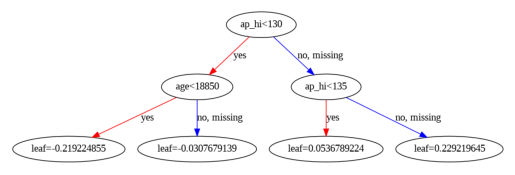

In [ ]:
plot_tree(XGB, num_trees=2)

plt.show
plt.savefig('XGB_decision_tree_max_depth2.pdf', dpi=2000,bbox_inches='tight')
